In [1]:
from db_connection import create_connection
from db_connection import query_data
from db_connection import query_sql_file
from db_connection import select_table

from preprocessing import process_admissions
from preprocessing import process_patients
from preprocessing import process_transfers

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
# Connect to the MIMIC-III database
con = create_connection()

# Admissions

In [4]:
admissions = select_table('admissions', con)
print(admissions.head())

   row_id  subject_id  hadm_id           admittime           dischtime  \
0      21          22   165315 2196-04-09 12:26:00 2196-04-10 15:54:00   
1      22          23   152223 2153-09-03 07:15:00 2153-09-08 19:10:00   
2      23          23   124321 2157-10-18 19:34:00 2157-10-25 14:00:00   
3      24          24   161859 2139-06-06 16:14:00 2139-06-09 12:48:00   
4      25          25   129635 2160-11-02 02:06:00 2160-11-05 14:55:00   

  deathtime admission_type         admission_location  \
0       NaT      EMERGENCY       EMERGENCY ROOM ADMIT   
1       NaT       ELECTIVE  PHYS REFERRAL/NORMAL DELI   
2       NaT      EMERGENCY  TRANSFER FROM HOSP/EXTRAM   
3       NaT      EMERGENCY  TRANSFER FROM HOSP/EXTRAM   
4       NaT      EMERGENCY       EMERGENCY ROOM ADMIT   

          discharge_location insurance language           religion  \
0  DISC-TRAN CANCER/CHLDRN H   Private     None       UNOBTAINABLE   
1           HOME HEALTH CARE  Medicare     None           CATHOLIC   
2 

In [5]:
print(admissions.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 58976 entries, 0 to 58975
Data columns (total 19 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   row_id                58976 non-null  int64         
 1   subject_id            58976 non-null  int64         
 2   hadm_id               58976 non-null  int64         
 3   admittime             58976 non-null  datetime64[ns]
 4   dischtime             58976 non-null  datetime64[ns]
 5   deathtime             5854 non-null   datetime64[ns]
 6   admission_type        58976 non-null  object        
 7   admission_location    58976 non-null  object        
 8   discharge_location    58976 non-null  object        
 9   insurance             58976 non-null  object        
 10  language              33644 non-null  object        
 11  religion              58518 non-null  object        
 12  marital_status        48848 non-null  object        
 13  ethnicity       

In [6]:
# check null values
print(admissions.isnull().sum())

row_id                      0
subject_id                  0
hadm_id                     0
admittime                   0
dischtime                   0
deathtime               53122
admission_type              0
admission_location          0
discharge_location          0
insurance                   0
language                25332
religion                  458
marital_status          10128
ethnicity                   0
edregtime               28099
edouttime               28099
diagnosis                  25
hospital_expire_flag        0
has_chartevents_data        0
dtype: int64


In [7]:
# check admission locations
print(admissions.admission_location.value_counts())

EMERGENCY ROOM ADMIT         22754
PHYS REFERRAL/NORMAL DELI    15079
CLINIC REFERRAL/PREMATURE    12032
TRANSFER FROM HOSP/EXTRAM     8456
TRANSFER FROM SKILLED NUR      273
** INFO NOT AVAILABLE **       204
HMO REFERRAL/SICK              102
TRANSFER FROM OTHER HEALT       71
TRSF WITHIN THIS FACILITY        5
Name: admission_location, dtype: int64


In [8]:
# check admission type
print(admissions.admission_type.value_counts())

EMERGENCY    42071
NEWBORN       7863
ELECTIVE      7706
URGENT        1336
Name: admission_type, dtype: int64


In [9]:
admissions = process_admissions.group_admission_type(admissions)
print(admissions.admission_type.value_counts())

EMERGENCY    43407
NEWBORN       7863
ELECTIVE      7706
Name: admission_type, dtype: int64


In [10]:
# check demographics
print(admissions.ethnicity.unique())

['WHITE' 'UNKNOWN/NOT SPECIFIED' 'MULTI RACE ETHNICITY'
 'BLACK/AFRICAN AMERICAN' 'HISPANIC OR LATINO'
 'PATIENT DECLINED TO ANSWER' 'ASIAN' 'OTHER'
 'HISPANIC/LATINO - GUATEMALAN' 'ASIAN - VIETNAMESE'
 'AMERICAN INDIAN/ALASKA NATIVE' 'WHITE - RUSSIAN'
 'HISPANIC/LATINO - PUERTO RICAN' 'ASIAN - CHINESE' 'ASIAN - ASIAN INDIAN'
 'BLACK/AFRICAN' 'HISPANIC/LATINO - SALVADORAN'
 'HISPANIC/LATINO - DOMINICAN' 'UNABLE TO OBTAIN' 'BLACK/CAPE VERDEAN'
 'BLACK/HAITIAN' 'WHITE - OTHER EUROPEAN' 'PORTUGUESE' 'SOUTH AMERICAN'
 'WHITE - EASTERN EUROPEAN' 'CARIBBEAN ISLAND' 'ASIAN - FILIPINO'
 'ASIAN - CAMBODIAN' 'HISPANIC/LATINO - CENTRAL AMERICAN (OTHER)'
 'WHITE - BRAZILIAN' 'ASIAN - KOREAN' 'HISPANIC/LATINO - COLOMBIAN'
 'ASIAN - JAPANESE' 'NATIVE HAWAIIAN OR OTHER PACIFIC ISLANDER'
 'ASIAN - THAI' 'HISPANIC/LATINO - HONDURAN' 'HISPANIC/LATINO - CUBAN'
 'MIDDLE EASTERN' 'ASIAN - OTHER' 'HISPANIC/LATINO - MEXICAN'
 'AMERICAN INDIAN/ALASKA NATIVE FEDERALLY RECOGNIZED TRIBE']


In [11]:
# grouping similar categories
admissions = process_admissions.group_ethnicities(admissions)
print(admissions.ethnicity.value_counts())

WHITE                   41386
OTHER/UNKNOWN            7408
BLACK                    5785
HISPANIC/LATINO          2128
ASIAN                    2050
MULTI RACE ETHNICITY      130
NATIVE AMERICAN            54
ISLANDER                   35
Name: ethnicity, dtype: int64


In [12]:
cross_tab_script = '../sql_scripts/admissions_cross_tab.sql'
query_list = query_sql_file(cross_tab_script, con)

admission_locations = query_data(query_list[0], con)
admission_types = query_data(query_list[1], con)

pivot_table = query_data(query_list[2], con)
print(pivot_table)

          Admission Location ELECTIVE EMERGENCY/URGENT NEWBORN
0   ** INFO NOT AVAILABLE **     None                5     199
1  CLINIC REFERRAL/PREMATURE       25            10002    1987
2       EMERGENCY ROOM ADMIT     None            22754    None
3          HMO REFERRAL/SICK     None                1     101
4  PHYS REFERRAL/NORMAL DELI     7646             1432    5553
5  TRANSFER FROM HOSP/EXTRAM       19              849      23
6  TRANSFER FROM OTHER HEALT        3                7    None
7  TRANSFER FROM SKILLED NUR       13               14    None
8  TRSF WITHIN THIS FACILITY     None                5    None


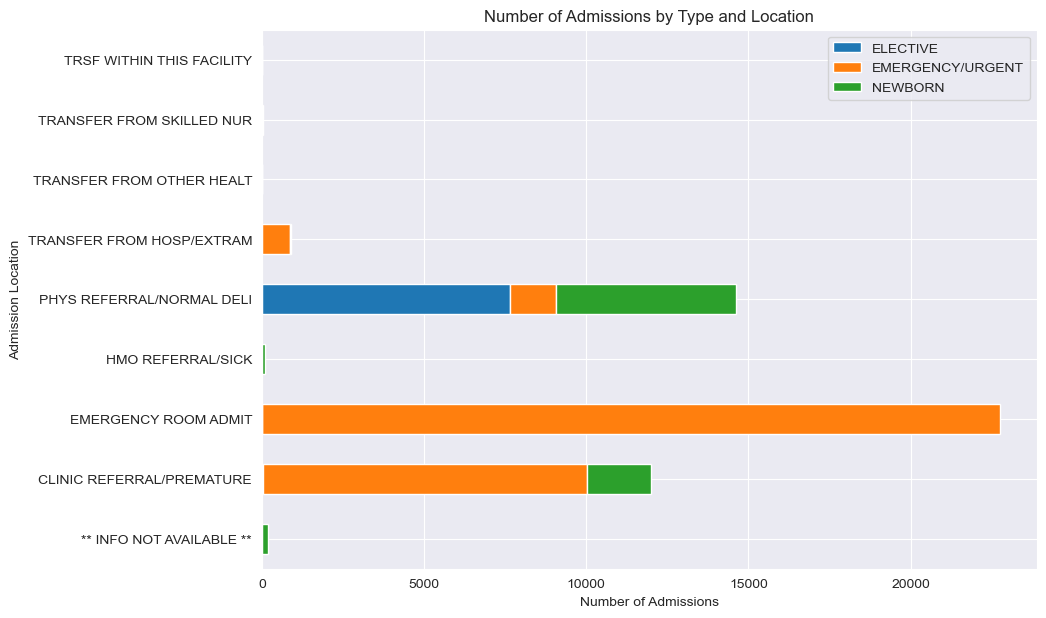

In [13]:
pivot_table.fillna(0, inplace=True)
pivot_table.set_index('Admission Location', inplace=True)

# First, convert the data types of the numerical columns to integer
for col in ['ELECTIVE', 'EMERGENCY/URGENT', 'NEWBORN']:
    pivot_table[col] = pivot_table[col].astype(int)

pivot_table.plot(kind='barh', stacked=True, figsize=(10, 7))

plt.xlabel('Number of Admissions')
plt.title('Number of Admissions by Type and Location')
plt.show()

In [14]:
# check preliminary diagnosis
print(admissions.diagnosis.unique())

['BENZODIAZEPINE OVERDOSE'
 'CORONARY ARTERY DISEASE\\CORONARY ARTERY BYPASS GRAFT/SDA' 'BRAIN MASS'
 ... 'R/O METASTASIS'
 'GASTROPARESIS\\PLACEMENT OF G-TUBE **REMOTE WEST**/SDA' 'JOINT EFFUSION']


# Patients

In [15]:
patients = select_table('patients', con)
print(patients.head())

   row_id  subject_id gender        dob        dod   dod_hosp dod_ssn  \
0     234         249      F 2075-03-13        NaT        NaT     NaT   
1     235         250      F 2164-12-27 2188-11-22 2188-11-22     NaT   
2     236         251      M 2090-03-15        NaT        NaT     NaT   
3     237         252      M 2078-03-06        NaT        NaT     NaT   
4     238         253      F 2089-11-26        NaT        NaT     NaT   

   expire_flag  
0            0  
1            1  
2            0  
3            0  
4            0  


In [16]:
print(patients.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 46520 entries, 0 to 46519
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   row_id       46520 non-null  int64         
 1   subject_id   46520 non-null  int64         
 2   gender       46520 non-null  object        
 3   dob          46520 non-null  datetime64[ns]
 4   dod          15759 non-null  datetime64[ns]
 5   dod_hosp     9974 non-null   datetime64[ns]
 6   dod_ssn      13378 non-null  datetime64[ns]
 7   expire_flag  46520 non-null  int64         
dtypes: datetime64[ns](4), int64(3), object(1)
memory usage: 2.8+ MB
None


In [17]:
# Adding patients first admission time
patients = process_patients.add_first_admission(patients, admissions)
print(patients.head())

   row_id  subject_id gender        dob        dod   dod_hosp dod_ssn  \
0     234         249      F 2075-03-13        NaT        NaT     NaT   
1     235         250      F 2164-12-27 2188-11-22 2188-11-22     NaT   
2     236         251      M 2090-03-15        NaT        NaT     NaT   
3     237         252      M 2078-03-06        NaT        NaT     NaT   
4     238         253      F 2089-11-26        NaT        NaT     NaT   

   expire_flag first_admittime  
0            0      2149-12-17  
1            1      2188-11-12  
2            0      2110-07-27  
3            0      2133-03-31  
4            0      2174-01-21  


In [18]:
print(patients.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 46520 entries, 0 to 46519
Data columns (total 9 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   row_id           46520 non-null  int64         
 1   subject_id       46520 non-null  int64         
 2   gender           46520 non-null  object        
 3   dob              46520 non-null  datetime64[ns]
 4   dod              15759 non-null  datetime64[ns]
 5   dod_hosp         9974 non-null   datetime64[ns]
 6   dod_ssn          13378 non-null  datetime64[ns]
 7   expire_flag      46520 non-null  int64         
 8   first_admittime  46520 non-null  datetime64[ns]
dtypes: datetime64[ns](5), int64(3), object(1)
memory usage: 3.5+ MB
None


In [19]:
# Calculating real age at first admission time
patients = process_patients.calc_age_at_admission(patients)
print(patients.head())

patients = patients.drop(columns=['first_admittime'])

   row_id  subject_id gender        dob        dod   dod_hosp dod_ssn  \
0     234         249      F 2075-03-13        NaT        NaT     NaT   
1     235         250      F 2164-12-27 2188-11-22 2188-11-22     NaT   
2     236         251      M 2090-03-15        NaT        NaT     NaT   
3     237         252      M 2078-03-06        NaT        NaT     NaT   
4     238         253      F 2089-11-26        NaT        NaT     NaT   

   expire_flag first_admittime  age_at_admission  
0            0      2149-12-17                74  
1            1      2188-11-12                24  
2            0      2110-07-27                20  
3            0      2133-03-31                55  
4            0      2174-01-21                85  


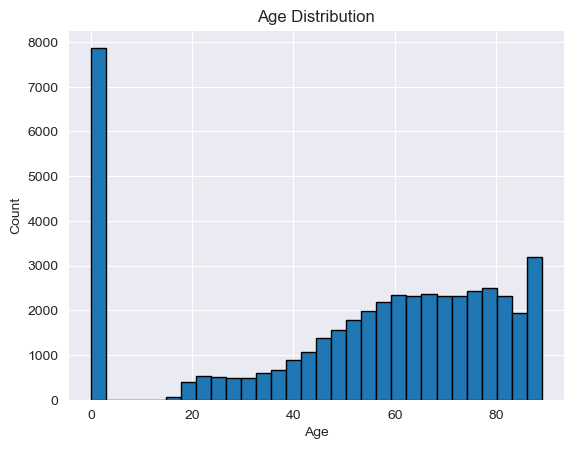

In [20]:
# Visualizing 'AGE' distribution in 'PATIENTS' table
plt.hist(patients['age_at_admission'], bins=30, edgecolor='black')
plt.xlabel('Age')
plt.ylabel('Count')
plt.title('Age Distribution')
plt.show()

In [21]:
print(patients.age_at_admission.median())
print(patients.age_at_admission.mean())

60.0
52.84765692175409


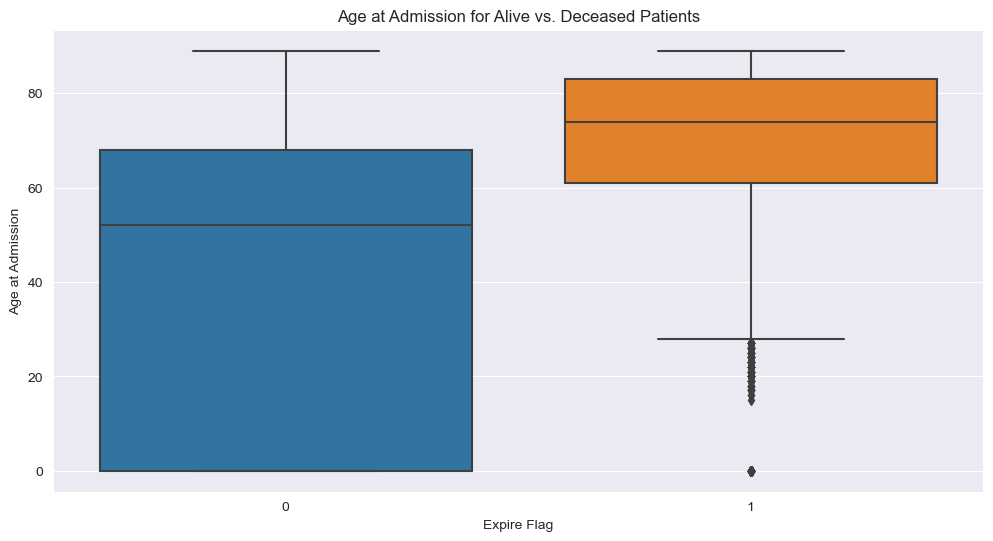

In [22]:
import seaborn as sns

# # boxplot
plt.figure(figsize=(12, 6))
sns.boxplot(x='expire_flag', y='age_at_admission', data=patients)
plt.xlabel('Expire Flag')
plt.ylabel('Age at Admission')
plt.title('Age at Admission for Alive vs. Deceased Patients')
plt.show()


In [23]:
# Find the patients that died in the hospital
deceased_subject_ids = admissions.subject_id[admissions.hospital_expire_flag == 1].tolist()
deceased_patients_in = patients[patients.subject_id.isin(deceased_subject_ids)]

# Find the patients that died outside the hospital
deceased_patients_out = patients[(patients.expire_flag == 1) & (~patients.subject_id.isin(deceased_subject_ids))]

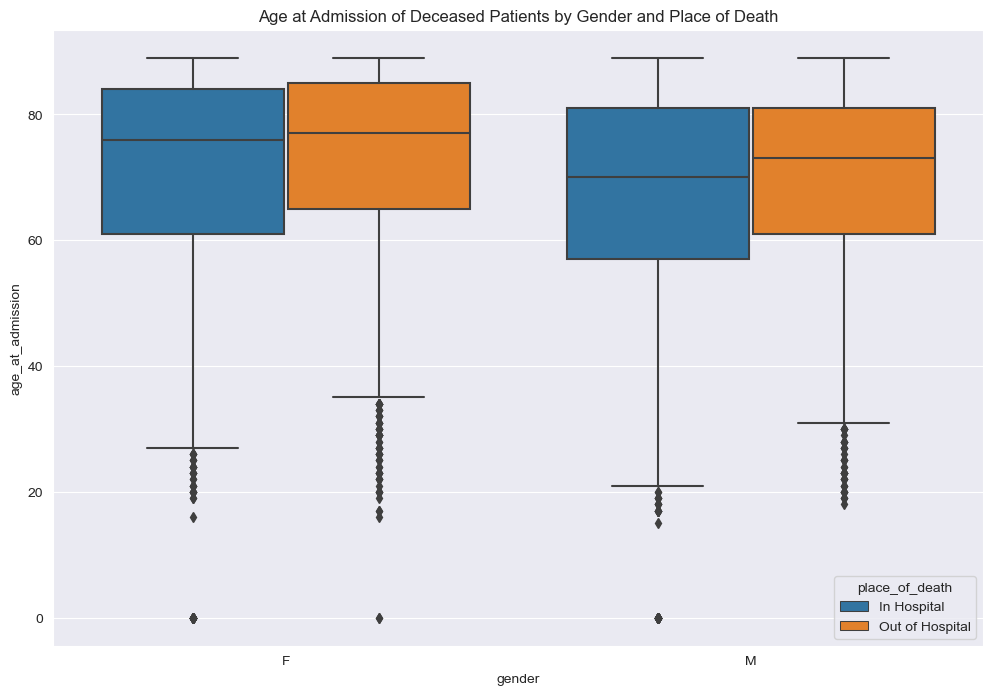

In [24]:
deceased_patients_in['place_of_death'] = 'In Hospital'
deceased_patients_out['place_of_death'] = 'Out of Hospital'
deceased_patients = pd.concat([deceased_patients_in, deceased_patients_out])

plt.figure(figsize=(12,8))
sns.boxplot(x='gender', y='age_at_admission', hue='place_of_death', data=deceased_patients)
plt.title('Age at Admission of Deceased Patients by Gender and Place of Death')
plt.show()

Text(0.5, 1.0, 'Gender Distribution')

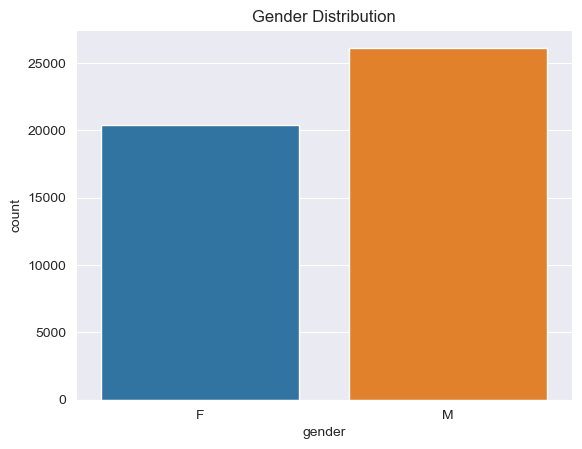

In [25]:
sns.countplot(data=patients, x='gender')
plt.title('Gender Distribution')

# ICUSTAYS

In [26]:
icustays = select_table('icustays', con)
print(icustays.head())

   row_id  subject_id  hadm_id  icustay_id dbsource first_careunit  \
0     365         268   110404      280836  carevue           MICU   
1     366         269   106296      206613  carevue           MICU   
2     367         270   188028      220345  carevue            CCU   
3     368         271   173727      249196  carevue           MICU   
4     369         272   164716      210407  carevue            CCU   

  last_careunit  first_wardid  last_wardid              intime  \
0          MICU            52           52 2198-02-14 23:27:38   
1          MICU            52           52 2170-11-05 11:05:29   
2           CCU            57           57 2128-06-24 15:05:20   
3          SICU            52           23 2120-08-07 23:12:42   
4           CCU            57           57 2186-12-25 21:08:04   

              outtime     los  
0 2198-02-18 05:26:11  3.2490  
1 2170-11-08 17:46:57  3.2788  
2 2128-06-27 12:32:29  2.8939  
3 2120-08-10 00:39:04  2.0600  
4 2186-12-27 12:01:13 

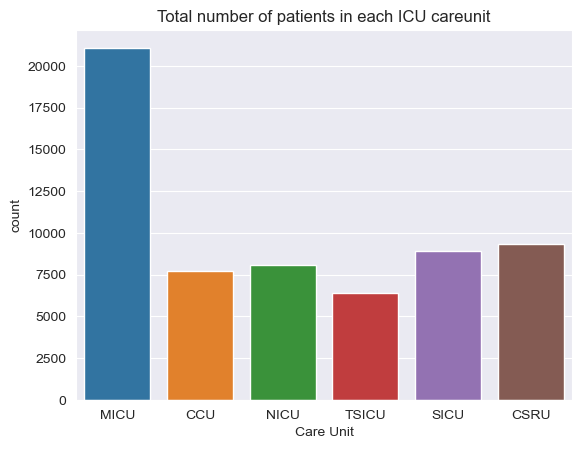

In [27]:
sns.countplot(data=icustays, x='first_careunit')
plt.title('Total number of patients in each ICU careunit')
plt.xlabel('Care Unit')
plt.show()

   row_id  subject_id  hadm_id  icustay_id dbsource first_careunit  \
0     365         268   110404      280836  carevue           MICU   
1     366         269   106296      206613  carevue           MICU   
2     367         270   188028      220345  carevue            CCU   
3     368         271   173727      249196  carevue           MICU   
4     369         272   164716      210407  carevue            CCU   

  last_careunit  first_wardid  last_wardid              intime  \
0          MICU            52           52 2198-02-14 23:27:38   
1          MICU            52           52 2170-11-05 11:05:29   
2           CCU            57           57 2128-06-24 15:05:20   
3          SICU            52           23 2120-08-07 23:12:42   
4           CCU            57           57 2186-12-25 21:08:04   

              outtime     los  hospital_expire_flag  
0 2198-02-18 05:26:11  3.2490                     1  
1 2170-11-08 17:46:57  3.2788                     0  
2 2128-06-27 12:32:2

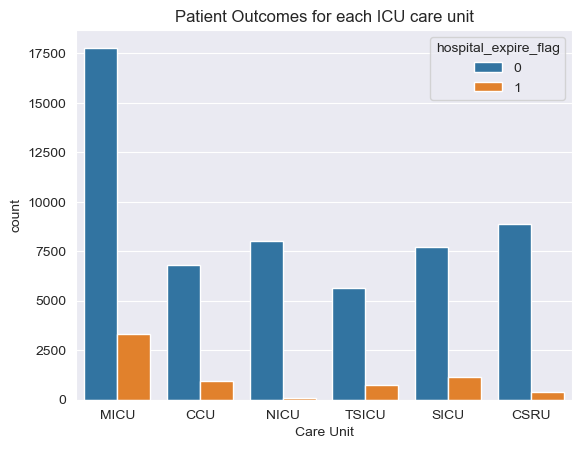

In [28]:
df = pd.merge(icustays, admissions[['hadm_id', 'subject_id', 'hospital_expire_flag']], on=['hadm_id', 'subject_id'], how='left')
print(df.head())
sns.countplot(data=df, x='first_careunit', hue='hospital_expire_flag')
plt.title('Patient Outcomes for each ICU care unit')
plt.xlabel('Care Unit')
plt.show()

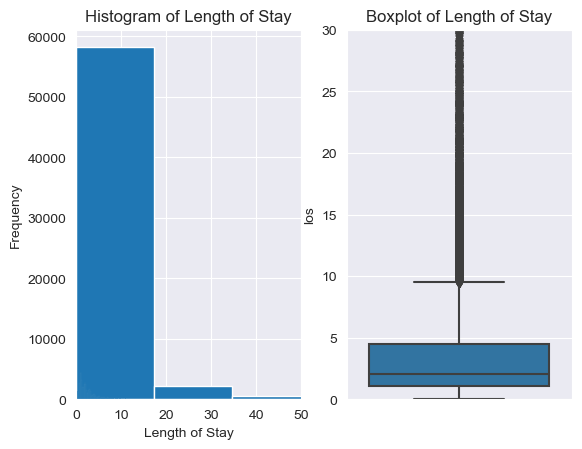

In [29]:
plt.subplot(1, 2, 1)
icustays.los.plot(kind='hist')
sns.histplot(data=icustays, x='los')

plt.xlim(0, 50)
plt.xlabel('Length of Stay')
plt.ylabel('Frequency')
plt.title('Histogram of Length of Stay')

plt.subplot(1, 2, 2)
sns.boxplot(data=icustays, y='los')
plt.ylim(0, 30)
plt.title('Boxplot of Length of Stay')

plt.show()

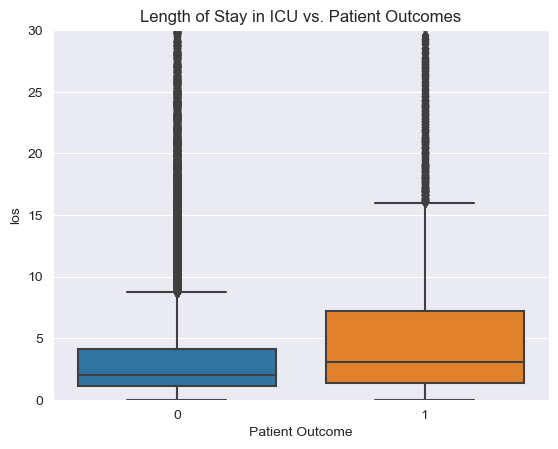

In [30]:
sns.boxplot(data=df, x='hospital_expire_flag', y='los')
plt.ylim(0, 30)
plt.title('Length of Stay in ICU vs. Patient Outcomes')
plt.xlabel('Patient Outcome')
plt.show()

# TRANSFERS

In [31]:
query = \
"""
SELECT a.hadm_id, t.hadm_id AS t_hadm_id
FROM admissions AS a
LEFT JOIN transfers AS t
ON a.hadm_id = t.hadm_id;
"""

result = query_data(query, con)
missing_services = result[result['t_hadm_id'].isnull()]

print(f"Number of missing HADM_IDs in transfers: {len(missing_services)}")

Number of missing HADM_IDs in transfers: 0


In [32]:
# Calculate the Total Length of Stay for each admission - includes ADMISSION, TRANSFER, and DISCHARGE
query = \
"""
SELECT hadm_id, SUM(los) as total_los
FROM transfers
GROUP BY hadm_id;
"""
transfers = query_data(query, con)
print(transfers.head())

   hadm_id  total_los
0   155703     262.73
1   130406     349.57
2   194150     120.18
3   117336      20.81
4   167276     673.05


In [33]:
# Only keep relevant features on the final version of the dataframes
admissions = process_admissions.clean_df(admissions)
patients = process_patients.clean_df(patients)
icustays = process_transfers.clean_icu(icustays)

In [34]:
admissions.head()

,subject_id,hadm_id,admission_type,admission_location,discharge_location,ethnicity,diagnosis,hospital_expire_flag,has_chartevents_data
0,22,165315,EMERGENCY,EMERGENCY ROOM ADMIT,DISC-TRAN CANCER/CHLDRN H,WHITE,BENZODIAZEPINE OVERDOSE,0,1
1,23,152223,ELECTIVE,PHYS REFERRAL/NORMAL DELI,HOME HEALTH CARE,WHITE,CORONARY ARTERY DISEASE\CORONARY ARTERY BYPASS...,0,1
2,23,124321,EMERGENCY,TRANSFER FROM HOSP/EXTRAM,HOME HEALTH CARE,WHITE,BRAIN MASS,0,1
3,24,161859,EMERGENCY,TRANSFER FROM HOSP/EXTRAM,HOME,WHITE,INTERIOR MYOCARDIAL INFARCTION,0,1
4,25,129635,EMERGENCY,EMERGENCY ROOM ADMIT,HOME,WHITE,ACUTE CORONARY SYNDROME,0,1


In [35]:
patients.head()

,subject_id,gender,expire_flag,age_at_admission
0,249,F,0,74
1,250,F,1,24
2,251,M,0,20
3,252,M,0,55
4,253,F,0,85


In [36]:
icustays.head()

,hadm_id,icustay_id,first_careunit,last_careunit,icu_los
0,110404,280836,MICU,MICU,3.2490
1,106296,206613,MICU,MICU,3.2788
2,188028,220345,CCU,CCU,2.8939
3,173727,249196,MICU,SICU,2.0600
4,164716,210407,CCU,CCU,1.6202


In [37]:
patient_stay_df = pd.merge(admissions, patients, on='subject_id', how='left')
patient_stay_df = pd.merge(patient_stay_df, transfers, on='hadm_id', how='left')
patient_stay_df = pd.merge(patient_stay_df, icustays, on='hadm_id', how='left')
print(patient_stay_df.head())

   subject_id  hadm_id admission_type         admission_location  \
0          22   165315      EMERGENCY       EMERGENCY ROOM ADMIT   
1          23   152223       ELECTIVE  PHYS REFERRAL/NORMAL DELI   
2          23   124321      EMERGENCY  TRANSFER FROM HOSP/EXTRAM   
3          24   161859      EMERGENCY  TRANSFER FROM HOSP/EXTRAM   
4          25   129635      EMERGENCY       EMERGENCY ROOM ADMIT   

          discharge_location ethnicity  \
0  DISC-TRAN CANCER/CHLDRN H     WHITE   
1           HOME HEALTH CARE     WHITE   
2           HOME HEALTH CARE     WHITE   
3                       HOME     WHITE   
4                       HOME     WHITE   

                                           diagnosis  hospital_expire_flag  \
0                            BENZODIAZEPINE OVERDOSE                     0   
1  CORONARY ARTERY DISEASE\CORONARY ARTERY BYPASS...                     0   
2                                         BRAIN MASS                     0   
3                     INTE

In [39]:
# Save the dataframe into a csv file to access it during model training
df.to_csv('../dataset/patient_stay_data.csv', index=False)